In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d, RegularGridInterpolator
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LogNorm
from scipy.integrate import trapz as integrate
from scipy.integrate import cumtrapz as cumintegrate
from functions import interp

from helper import *
import const


In [2]:
elements = SimpleNamespace(**np.load('elements.npz'))

In [3]:
with open('../EPICS/EEDL.txt', 'r') as f:
    lines_all = f.readlines()


In [4]:
code = {
    '23501': 'sig_tot',
    '23522': 'sig_ion',
    '23525': 'sig_scat_la',
    '23526': 'sig_scat',
    '23527': 'sig_brem',
    '23528': 'sig_exc',
    '23534': 'sig_ion_K',
    '23535': 'sig_ion_L1',
    '23536': 'sig_ion_L2',
    '23537': 'sig_ion_L3',
    '23538': 'sig_ion_M1',
    '23539': 'sig_ion_M2',
    '23540': 'sig_ion_M3',
    '23541': 'sig_ion_M4',
    '23542': 'sig_ion_M5',
    '23543': 'sig_ion_N1',
    '23544': 'sig_ion_N2',
    '23545': 'sig_ion_N3',
    '23546': 'sig_ion_N4',
    '23547': 'sig_ion_N5',
    '23548': 'sig_ion_N6',
    '23549': 'sig_ion_N7',
    '23550': 'sig_ion_O1',
    '23551': 'sig_ion_O2',
    '23552': 'sig_ion_O3',
    '23553': 'sig_ion_O4',
    '23554': 'sig_ion_O5',
    '23555': 'sig_ion_O6',
    '23556': 'sig_ion_O7',
    '23559': 'sig_ion_P1',
    '23560': 'sig_ion_P2',
    '23561': 'sig_ion_P3',
    '23562': 'sig_ion_P4',
    '23563': 'sig_ion_P5',
    '23570': 'sig_ion_Q1',
    '26525': 'th_scat',
    '26527': 'spec_brem',
    '26528': 'spec_exc',
    '26534': 'spec_ion_K',
    '26535': 'spec_ion_L1',
    '26536': 'spec_ion_L2',
    '26537': 'spec_ion_L3',
    '26538': 'spec_ion_M1',
    '26539': 'spec_ion_M2',
    '26540': 'spec_ion_M3',
    '26541': 'spec_ion_M4',
    '26542': 'spec_ion_M5',
    '26543': 'spec_ion_N1',
    '26544': 'spec_ion_N2',
    '26545': 'spec_ion_N3',
    '26546': 'spec_ion_N4',
    '26547': 'spec_ion_N5',
    '26548': 'spec_ion_N6',
    '26549': 'spec_ion_N7',
    '26550': 'spec_ion_O1',
    '26551': 'spec_ion_O2',
    '26552': 'spec_ion_O3',
    '26553': 'spec_ion_O4',
    '26554': 'spec_ion_O5',
    '26555': 'spec_ion_O6',
    '26556': 'spec_ion_O7',
    '26559': 'spec_ion_P1',
    '26560': 'spec_ion_P2',
    '26561': 'spec_ion_P3',
    '26562': 'spec_ion_P4',
    '26563': 'spec_ion_P5',
    '26570': 'spec_ion_Q1'
}


In [5]:
nelem = 99
ndtype = len(code)


In [6]:
lines_sorted = np.empty((nelem, ndtype), dtype=object)
for i in range(nelem):
    for j in range(ndtype):
        lines_sorted[i, j] = []

for line in lines_all:
     
    if line[66:68] == '  ': continue
    if line[70:75] not in code.keys(): continue
    
    Zelem = int(line[66:68])
    dtype_idx = list(code.keys()).index(line[70:75])
    line_data = [line[0:11], line[11:22], line[22:33], line[33:44], line[44:55], line[55:66]]
    line_data = np.array([float(val) if val != '           ' else np.nan for val in line_data])
    lines_sorted[Zelem-1, dtype_idx].append(line_data)
    
for i in range(nelem):
    for j in range(ndtype):
        lines_sorted[i, j] = np.array(lines_sorted[i, j])
        

In [7]:
data_all = np.empty((nelem, ndtype), dtype=object)

for i in range(nelem):
    for j in range(ndtype):
        
        lines = lines_sorted[i, j]
        dtype_name = list(code.values())[j]
        if lines.size == 0: continue
        
        if dtype_name[:3] == 'sig':
            
            ener, sig = lines[3:].flatten().reshape(-1, 2).T
            ener, sig = ener[~np.isnan(ener)], sig[~np.isnan(sig)]
            sig = sig*const.ba
            
            data = (ener, sig)
            if dtype_name[:7] == 'sig_ion' and len(dtype_name) > 7: 
                ener_bind = lines[1, 0]
                data += (ener_bind,)
            
        if dtype_name == 'th_scat':
            
            idx_line_new_ener = np.argwhere(lines[8:, 0]==0).flatten()
            ener_list = lines[8:, 1][idx_line_new_ener]
            data = np.empty(ener_list.size, dtype=object)

            for k, ener in enumerate(ener_list):

                idx_line_min = idx_line_new_ener[k]+1
                idx_line_max = idx_line_new_ener[k+1] if k<ener_list.size-1 else -1
                cos_th_scat, cos_th_pdf = lines[8:, :][idx_line_min:idx_line_max].flatten().reshape(-1, 2).T
                cos_th_scat, cos_th_pdf = cos_th_scat[~np.isnan(cos_th_scat)], cos_th_pdf[~np.isnan(cos_th_pdf)]
                data[k] = (ener, cos_th_scat, cos_th_pdf)
                
        if dtype_name == 'spec_exc':
            
            ener, ener_loss = lines[6:].flatten().reshape(-1, 2).T
            ener, ener_loss = ener[~np.isnan(ener)], ener_loss[~np.isnan(ener_loss)]
            data = (ener, ener_loss)
            
        if dtype_name == 'spec_brem':
            
            idx_line_elec = np.argwhere(lines[6:, 0]==0).flatten()[-1]+8
            ener, ener_loss = lines[idx_line_elec:].flatten().reshape(-1, 2).T
            ener, ener_loss = ener[~np.isnan(ener)], ener_loss[~np.isnan(ener_loss)]
            data = (ener, ener_loss)
            
        if dtype_name[:8] == 'spec_ion':
            
            idx_line_new_ener = np.argwhere(lines[6:, 0]==0).flatten()
            ener_list = lines[6:, 1][idx_line_new_ener]
            data = np.empty(ener_list.size, dtype=object)

            for k, ener in enumerate(ener_list):

                idx_line_min = idx_line_new_ener[k]+1
                idx_line_max = idx_line_new_ener[k+1] if k<ener_list.size-1 else -1
                ener_loss, ener_loss_pdf = lines[6:, :][idx_line_min:idx_line_max].flatten().reshape(-1, 2).T
                ener_loss, ener_loss_pdf = ener_loss[~np.isnan(ener_loss)] + ener_bind, ener_loss_pdf[~np.isnan(ener_loss_pdf)]
                data[k] = (ener, ener_loss, ener_loss_pdf)
        
        data_all[i, j] = data
            

In [202]:
np.savez('EEDL', dtype_list=np.array(list(code.values())), data=data_all)


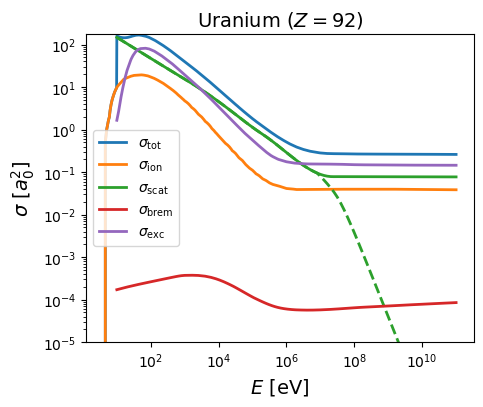

In [298]:
Zelem = 92

fig, ax = plt.subplots(figsize=(5, 4))

sig_name_list = ['sig_tot', 'sig_ion', 'sig_scat_la', 'sig_scat', 'sig_brem', 'sig_exc']
label_list = [r'$\sigma_{\rm tot}$', r'$\sigma_{\rm ion}$', None, r'$\sigma_{\rm scat}$', r'$\sigma_{\rm brem}$', r'$\sigma_{\rm exc}$']
color_list = ['C0', 'C1', 'C2', 'C2', 'C3', 'C4']
linestyle_list = ['-', '-', '--', '-', '-', '-']

for i, sig_name in enumerate(sig_name_list):

    dtype_idx = list(code.values()).index(sig_name)
    ener, sig = data_all[Zelem-1, dtype_idx]
    ax.plot(ener, sig/const.a0**2, label=label_list[i], color=color_list[i], linestyle=linestyle_list[i], lw=2)

ax.set_ylim(1e-5)
    
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$E$ [eV]', fontsize=14)
ax.set_ylabel(r'$\sigma$ [$a_0^2$]', fontsize=14)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)

ax.legend()


/var/folders/k0/yybwzjk54bg00p8q3ykchsx80000gp/T/ipykernel_70464/597359151.py:21: RuntimeWarning: divide by zero encountered in log
  sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')


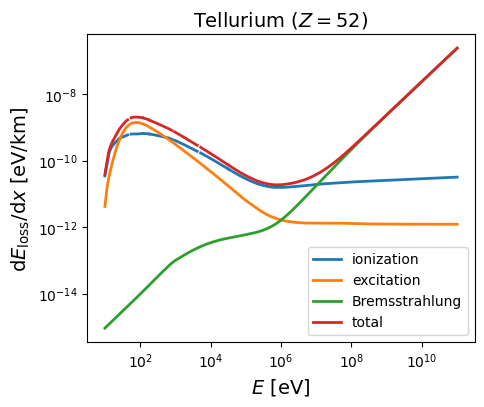

In [214]:
Zelem = 52
n = 1

fig, ax = plt.subplots(figsize=(5, 4))

ener_reg = np.logspace(1, 11, 512)
ener_loss_ion_reg = np.zeros_like(ener_reg)

sig_name_list = []
sig_list = []

for i in range(ndtype):
    
    dtype_name = list(code.values())[i]
    if dtype_name[:7] != 'sig_ion' or len(dtype_name)==7: continue
        
    data = data_all[Zelem-1, i]
    if type(data) == type(None): continue
        
    ener, sig, ener_bind = data
    sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')
    sig_reg = np.exp(sig_func(np.log(ener_reg)))
    sig_reg[ener_reg<ener_bind] = 0
    
    sig_name_list.append(dtype_name)
    sig_list.append(sig_reg)

for i in range(ndtype):
    
    dtype_name = list(code.values())[i]
    if dtype_name[:8] != 'spec_ion': continue

    data = data_all[Zelem-1, i]
    if np.all(data) == None: continue

    ener_list = np.array([data_ener[0] for data_ener in data])
    ener_loss_avg = np.zeros_like(ener_list)

    for j, data_ener in enumerate(data):

        ener, ener_loss, ener_loss_pdf = data_ener
        ener_loss_avg[j] = integrate(np.array(ener_loss_pdf)*np.array(ener_loss), np.array(ener_loss))/integrate(ener_loss_pdf, ener_loss)
    
    ener_loss_avg_func = interp1d(np.log(ener_list), np.log(ener_loss_avg), fill_value='extrapolate')
    ener_loss_avg_reg = np.exp(ener_loss_avg_func(np.log(ener_reg)))
    ener_loss_avg_reg[ener_reg<ener_bind] = 0
    
    sig_reg = sig_list[sig_name_list.index('sig_%s'%dtype_name[5:])]
    ener_loss_ion_reg += ener_loss_avg_reg*sig_reg/n

idx_dtype = list(code.values()).index('sig_exc')
ener, sig = data_all[Zelem-1, idx_dtype]
sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')
sig_reg = np.exp(sig_func(np.log(ener_reg)))

idx_dtype = list(code.values()).index('spec_exc')
ener, ener_loss = data_all[Zelem-1, idx_dtype]
ener_loss_func = interp1d(np.log(ener), np.log(ener_loss), fill_value='extrapolate')
ener_loss_exc_reg = np.exp(ener_loss_func(np.log(ener_reg)))*sig_reg/n

idx_dtype = list(code.values()).index('sig_brem')
ener, sig = data_all[Zelem-1, idx_dtype]
sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')
sig_reg = np.exp(sig_func(np.log(ener_reg)))

idx_dtype = list(code.values()).index('spec_brem')
ener, ener_loss = data_all[Zelem-1, idx_dtype]
ener_loss_func = interp1d(np.log(ener), np.log(ener_loss), fill_value='extrapolate')
ener_loss_brem_reg = np.exp(ener_loss_func(np.log(ener_reg)))*sig_reg/n

ener_loss_tot_reg = ener_loss_ion_reg + ener_loss_exc_reg + ener_loss_brem_reg

ax.plot(ener_reg, ener_loss_ion_reg/(1/const.km), lw=2, label='ionization')
ax.plot(ener_reg, ener_loss_exc_reg/(1/const.km), lw=2, label='excitation')
ax.plot(ener_reg, ener_loss_brem_reg/(1/const.km), lw=2, label='Bremsstrahlung')
ax.plot(ener_reg, ener_loss_tot_reg/(1/const.km), lw=2, label='total')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$E$ [eV]', fontsize=14)
ax.set_ylabel(r'${\rm d}E_{\rm loss}/{\rm d}x$ [eV/km]', fontsize=14)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)

ax.legend()
    

Text(0.5, 1.0, 'Tellurium ($Z=52$)')

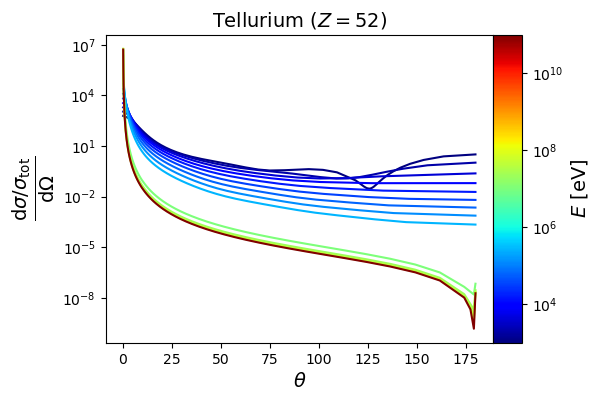

In [10]:
Zelem = 52

fig, ax = plt.subplots(figsize=(5, 4))

idx_dtype = list(code.values()).index('th_scat')
data = data_all[Zelem-1, idx_dtype]
ener_list = np.array([data_ener[0] for data_ener in data])
norm = LogNorm(1e3, 1e11)

cmap = mpl.colormaps['jet']
color_list = cmap(norm(ener_list))

for i, data_ener in enumerate(data):
    
    ener, cos_th_scat, cos_th_pdf = data_ener
    ax.plot(np.arccos(cos_th_scat)*180/np.pi, 2*np.pi*cos_th_pdf, color=color_list[i])
    
ax.set_yscale('log')

sm = ScalarMappable(LogNorm(1e3, 1e11), cmap=cmap)

cax = ax.inset_axes([1, 0, 0.075, 1])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r'$E$ [${\rm eV}$]', fontsize=14)

ax.set_xlabel(r'$\theta$', fontsize=14)
ax.set_ylabel(r'$\frac{{\rm d}\sigma/\sigma_{\rm tot}}{{\rm d}\Omega}$', fontsize=20)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)


Text(0.5, 1.0, 'Uranium ($Z=92$)')

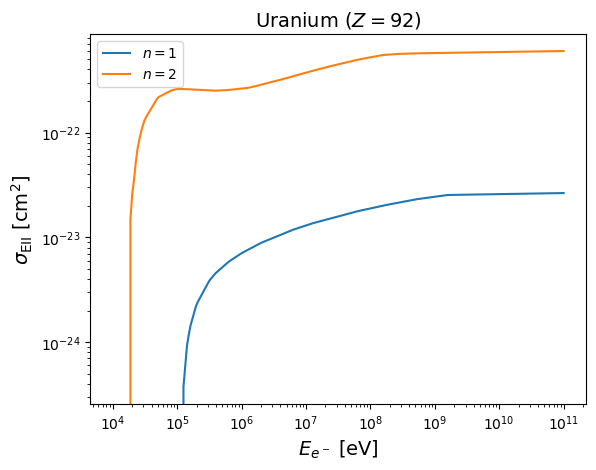

In [411]:
Zelem = 92

num = 256
ener0_list = np.logspace(4, 11, num)
idx_list = [list(code.values()).index(dtype) for dtype in ['sig_ion_K', 'sig_ion_L1', 'sig_ion_L2', 'sig_ion_L3']]
sig_list = np.zeros((len(idx_list), num))

for i, idx in enumerate(idx_list):

    data = data_all[Zelem-1, idx]
    ener, sig, ener_bind = data
    
    for j, ener0 in enumerate(ener0_list):
        
        sig_list[i, j] = interp(ener0, ener, sig, logx=True, logy=True)

plt.plot(ener0_list, sig_list[0], label=r'$n=1$')
plt.plot(ener0_list, np.sum(sig_list[1:], axis=0), label=r'$n=2$')

plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.xlabel(r'$E_{e^-}$ [${\rm eV}$]', fontsize=14)
plt.ylabel(r'$\sigma_{\rm EII}$ [${\rm cm^2}$]', fontsize=14)
plt.title(r'%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)
        
# save_fig('sig_EII')
    

Text(0.5, 1.0, '$3s_{1/2}$ subshell, $E_{e^-} = 1~{\\rm MeV}$')

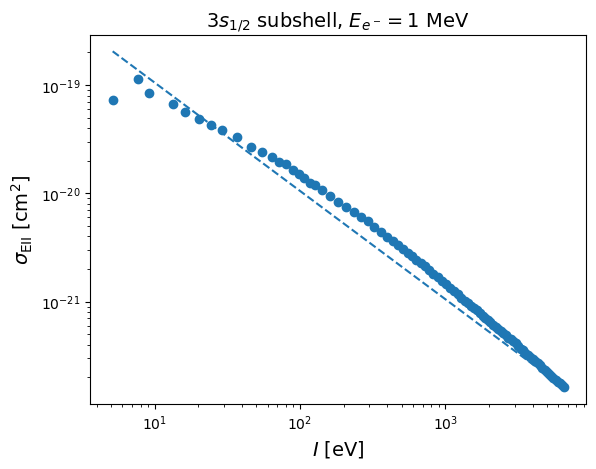

In [412]:
ener0 = 1000000

Zelem_list = range(11, 98)
idx = list(code.values()).index('sig_ion_M1')

ener_bind_list = []
sig_list = []

for Zelem in Zelem_list:
    
    data = data_all[Zelem-1, idx]
    ener, sig, ener_bind = data
    sig_i = interp(ener0, ener, sig, logx=True, logy=True)
    
    ener_bind_list.append(ener_bind)
    sig_list.append(sig_i)
    
ener_bind_list, sig_list = np.array(ener_bind_list), np.array(sig_list)
    
plt.loglog(ener_bind_list, sig_list, lw=2, marker='o', linestyle='')

ener_bind_s = np.logspace(np.log10(ener_bind_list[0]), np.log10(ener_bind_list[-1]), 256)
plt.plot(ener_bind_s, sig_list[-1]*(ener_bind_list[-1]/ener_bind_s)**1, color='C0', linestyle='--')

plt.xlabel(r'$I$ [${\rm eV}$]', fontsize=14)
plt.ylabel(r'$\sigma_{\rm EII}$ [${\rm cm^2}$]', fontsize=14)
plt.title(r'$3s_{1/2}$ subshell, $E_{e^-} = 1~{\rm MeV}$', fontsize=14)

# save_fig('sig_EII')


In [396]:
ener = 1000000

ener0 = const.m_e*const.c**2
ener_kin = ener*const.eV
ener_tot = ener0 + ener_kin

ener_tot_cm = np.sqrt(const.m_e*const.c**2/2 * (2*const.m_e*const.c**2 + ener*const.eV))
gam_cm = ener_tot_cm/ener0
beta_cm = np.sqrt(1 - 1/gam_cm**2)
pmag_cm = gam_cm*const.m_e*beta_cm*const.c


sig: 6.03e-21
avg ener loss: 2.76e+03 eV
avg th scat: 1.92 deg
1.6648609724382086e-17


Text(0, 0.5, '$\\sigma$ [${\\rm cm^2}$]')

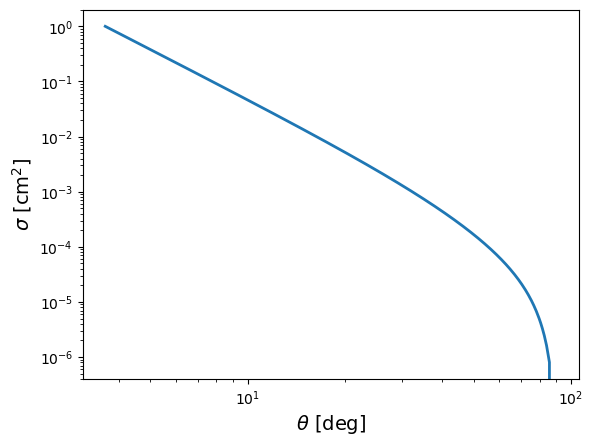

In [515]:
frac_lim = 1e-3
cos_th_lim = 1 - 2*frac_lim
sin_th_lim = np.sqrt(1-cos_th_lim**2)
sin_th = np.logspace(np.log10(sin_th_lim), 0, 1024)[::-1]
cos_th = np.sqrt(1-sin_th**2)

fac1 = (ener_tot_cm**2-const.m_e**2*const.c**4)**2
fac2 = (8*ener_tot_cm**4 - 4*const.m_e**2*const.c**4*ener_tot_cm**2 - const.m_e**4*const.c**8) / fac1
fac3 = 4*(2*ener_tot_cm**2 - const.m_e**2*const.c**4)**2 / fac1
fac4 = const.alpha**2*const.hbar**2*const.c**2/(4*ener_tot_cm**2)

sig = 4*np.pi*fac4*(1-sin_th_lim + fac2*(1-1/sin_th_lim) - fac3/3*(1-1/sin_th_lim**3) )
sig_pdf = 4*np.pi*fac4*(1 - fac2/sin_th**2 + fac3/sin_th**4) / sig
sig_cdf = 4*np.pi*fac4*(1-sin_th + fac2*(1-1/sin_th) - fac3/3*(1-1/sin_th**3) ) / sig

cos_th_scat = np.sqrt((2*ener0+ener_kin)*(1+cos_th)/(4*ener0+ener_kin*(1+cos_th)))
ener_loss = ener/2*(1-cos_th)

th_scat_avg = -integrate(np.arccos(cos_th_scat)*sig_pdf, sin_th)
ener_loss_avg = -integrate(ener_loss*sig_pdf, sin_th)

print('sig: %.3g' % sig)
print('avg ener loss: %.3g eV' % ener_loss_avg)
print('avg th scat: %.3g deg' % (th_scat_avg*180/np.pi))
print(ener_loss_avg*sig)

plt.plot(np.arcsin(sin_th)*180/np.pi, sig_cdf, lw=2)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\theta$ [${\rm deg}$]', fontsize=14)
plt.ylabel(r'$\sigma$ [${\rm cm^2}$]', fontsize=14)


In [544]:
xi = np.random.random()
sin_th_cm = interp(xi, sig_cdf, sin_th, logx=True, logy=True)
cos_th_cm = np.sqrt(1-sin_th_cm**2)

print(cos_th_cm)

ener_loss = ener/2*(1-cos_th_cm)
cos_th_lab = np.sqrt((2*ener0+ener_kin)*(1+cos_th_cm)/(4*ener0+ener_kin*(1+cos_th_cm)))

ener_loss, np.arccos(cos_th_lab)*180/np.pi


0.9975234468759976


(1238.276562001206, 1.4339847985275094)

In [367]:
cos_th_lim_list = 1-np.logspace(-6, -1)[::-1]
sig_list = np.zeros_like(cos_th_lim_list)
ener_loss_avg_list = np.zeros_like(cos_th_lim_list)
th_fin_avg_list = np.zeros_like(cos_th_lim_list)

for i, cos_th_lim in enumerate(cos_th_lim_list):

    sin_th_lim = np.sqrt(1-cos_th_lim**2)
    tan_th_lim = sin_th_lim/cos_th_lim

    cos_th = 1-np.logspace(np.log10(1-cos_th_lim), 0, 1024)[:-1][::-1]
    sin_th = np.sqrt(1-cos_th**2)
    tan_th = sin_th/cos_th

    fac1 = (ener_tot_cm**2-const.m_e**2*const.c**4)**2
    fac2 = (8*ener_tot_cm**4 - 4*const.m_e**2*const.c**4*ener_tot_cm**2 - const.m_e**4*const.c**8) / fac1
    fac3 = 4*(2*ener_tot_cm**2 - const.m_e**2*const.c**4)**2 / fac1
    fac4 = const.alpha**2*const.hbar**2*const.c**2/(4*ener_tot_cm**2)

    sig = 2*np.pi*fac4*(cos_th_lim + fac3/tan_th_lim**2 + fac2*np.arctanh(cos_th_lim) + fac2*np.log(2/(1+cos_th_lim)-1))
    sig_pdf = 4*np.pi*fac4*(1 - fac2/sin_th**2 + fac3/sin_th**4) / sig
    sig_cdf = 2*np.pi*fac4*(cos_th*(2+fac3/np.sqrt(1-cos_th**2)) + fac3*np.arctanh(cos_th) + fac2*np.log(2/(1+cos_th)-1)) / sig

    ener_tot_fin = gam_cm*(ener_tot_cm + beta_cm*cos_th*pmag_cm*const.c)
    ener_loss = ener - (ener_tot_fin-ener0)/const.eV
    ener_loss_avg = integrate(ener_loss*sig_pdf, cos_th)
    
    ppar_fin = gam_cm*(cos_th*pmag_cm + beta_cm*ener_tot_cm/const.c)
    pperp_fin = sin_th*pmag_cm
    cos_th_fin = ppar_fin/np.sqrt(ppar_fin**2+pperp_fin**2)
    th_fin = np.arccos(cos_th_fin)
    th_fin_avg = integrate(th_fin*sig_pdf, cos_th)
    
    sig_list[i] = sig
    ener_loss_avg_list[i] = ener_loss_avg
    th_fin_avg_list[i] = th_fin_avg


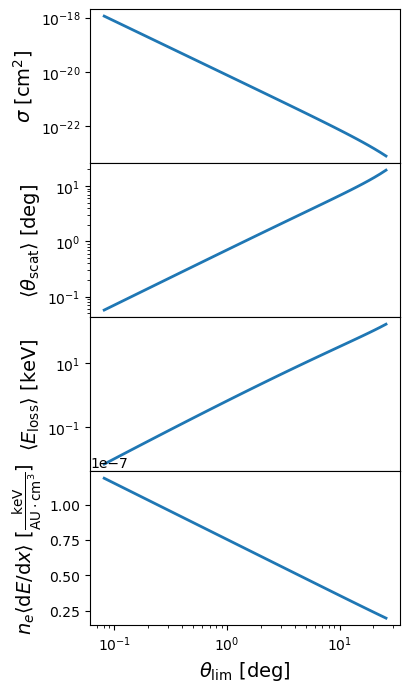

In [1900]:
fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(4, 8))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

axs[0].plot(np.arccos(cos_th_lim_list)*180/np.pi, sig_list, lw=2)
axs[1].plot(np.arccos(cos_th_lim_list)*180/np.pi, th_fin_avg_list*180/np.pi, lw=2)
axs[2].plot(np.arccos(cos_th_lim_list)*180/np.pi, ener_loss_avg_list/1e3, lw=2)
axs[3].plot(np.arccos(cos_th_lim_list)*180/np.pi, sig_list*ener_loss_avg_list*const.AU/1e3, lw=2)

axs[3].set_xlabel(r'$\theta_{\rm lim}$ [${\rm deg}$]', fontsize=14)
axs[0].set_ylabel(r'$\sigma$ [${\rm cm^2}$]', fontsize=14)
axs[1].set_ylabel(r'$\langle \theta_{\rm scat} \rangle$ [${\rm deg}$]', fontsize=14)
axs[2].set_ylabel(r'$\langle E_{\rm loss} \rangle$ [${\rm keV}$]', fontsize=14)
axs[3].set_ylabel(r'$n_{e}\langle {\rm d}E/{\rm d} x \rangle$ [${\rm \frac{keV}{AU \cdot cm^3}}$]', fontsize=14)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
#axs[3].set_yscale('log')

#save_fig('moller')
